# Exploratory Data Analysis

In [1]:
import pandas as pd
from DonorIdeo.littlesis_graph_utils import build_littlesis_graph
from DonorIdeo.config import DATABASE_PATH, ASSETS_DIR
import networkx as nx
from typing import List
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pathlib import Path

In [2]:
# CONSTANTS
DATABASE: pd.DataFrame = pd.read_csv(DATABASE_PATH)

# The projection should be flipped such that the democrats are on the left and the republicans are on the right
# This is done by multiplying the projection by -1
DATABASE["reduced-projection-1d"] = -1 * DATABASE["reduced-projection-1d"]
DATABASE["projection-1d"] = -1 * DATABASE["projection-1d"]
DATABASE["minimum-projection-1d"] = -1 * DATABASE["minimum-projection-1d"]

G, G_largest = build_littlesis_graph()

Reading /Users/viktorduepedersen/Documents/github/DonorIdeo/data/sources/littlesis-entities.json
Reading /Users/viktorduepedersen/Documents/github/DonorIdeo/data/sources/littlesis-relationships.json


In [3]:
def write_graph_info(G: nx.Graph, outpath: Path):
    with open(outpath, "w") as outfile:
        outfile.write(f"File generated at {pd.Timestamp.now()} \n")

        # basic info
        outfile.write("Basic info: \n")
        outfile.write(f"Number of nodes: {G.number_of_nodes()} \n")
        outfile.write(f"Number of edges: {G.number_of_edges()} \n")
        outfile.write(
            f"Number of connected components: {nx.number_connected_components(G)} \n"
        )
        connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
        three_largest_components = connected_components[0:3]
        for i, component in enumerate(three_largest_components):
            outfile.write(
                f"{i+1}. Size of the connected component: {(len(component)/G.number_of_nodes())*100:.2f}% \n"
            )

        outfile.write("\n")

        # top 20 nodes based on pagerank
        pr = nx.pagerank(G)
        top_20_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[0:20]
        outfile.write("Top 20 nodes based on pagerank: \n")
        for i, node in enumerate(top_20_pr):
            node_id, node_pr = node
            node_name: str = G.nodes[node_id]["name"]
            outfile.write(f"{i+1}.\t({node_id})\t\t{node_name}\t{node_pr:.5f} \n")

        outfile.write("\n")

        # Ranking only politicians from the DATABASE
        outfile.write("Ranking only politicians from the DATABASE: \n")
        littlesis_ids: List[int] = DATABASE["littlesis"].dropna().unique().tolist()

        # obtain the pr for only the politicians
        pr_politicians = {k: v for k, v in pr.items() if k in littlesis_ids}
        top_200_pr_politicians = sorted(
            pr_politicians.items(), key=lambda x: x[1], reverse=True
        )[0:200]
        for i, node in enumerate(top_200_pr_politicians):
            node_id, node_pr = node
            node_name: str = G.nodes[node_id]["name"]
            node_party: str = DATABASE[DATABASE["littlesis"] == node_id][
                "party"
            ].values[0]
            outfile.write(
                f"{i+1}.\t{node_party}\t\t({node_id})\t\t{node_name}: {node_pr:.5f} \n"
            )


# write_graph_info(G, ASSETS_DIR / "graph_info.txt")
# write_graph_info(G_largest, ASSETS_DIR / "graph_largest_info.txt")

# Degree distribution of the graph and only politicians in database.csv

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def compute_degree_distribution(G: nx.Graph, outpath: Path) -> None:
    """
    Compute the degree distribution of a graph and save it in a json file.
    """
    degree_distribution: List[int] = nx.degree_histogram(G)

    fig = make_subplots(
        rows=1,
        cols=1,
        subplot_titles=("Degree Distribution", "Degree Distribution (log-log)"),
    )
    fig.add_trace(
        go.Scatter(x=list(range(len(degree_distribution))), y=degree_distribution),
        row=1,
        col=1,
    )
    # Make the y-axis of the log-log plot logarithmic
    fig.update_yaxes(type="log", row=1, col=1)
    fig.update_xaxes(type="log", row=1, col=1)
    fig.write_image(outpath)


compute_degree_distribution(G_largest, ASSETS_DIR / "graph_degree_distribution.png")
compute_degree_distribution(
    G_largest, ASSETS_DIR / "graph_largest_degree_distribution.png"
)

# Nominate Dim 1

In [5]:
senate: pd.DataFrame = DATABASE[DATABASE["chamber"] == "Senate"]
house: pd.DataFrame = DATABASE[DATABASE["chamber"] == "House"]

fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Senate", "House of Representatives"),
)

fig.add_trace(
    go.Scatter(
        x=senate["nominate_dim1"],
        mode="markers",
        marker_color=senate["color"],
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=house["nominate_dim1"],
        mode="markers",
        marker_color=house["color"],
    ),
    row=2,
    col=1,
)

fig.update_layout(
    title="Voteview nominate_dim1",
    xaxis_title="",
    yaxis_title="",
    height=600,
    width=1000,
    showlegend=False,
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
)

fig.update_yaxes(showticklabels=False)
fig.update_xaxes(range=[-1, 1])
fig.write_image(ASSETS_DIR / "voteview-nominate-dim1.png")
fig.show()

# Reduced projection of the graph

In [6]:
# Plot the 1D projections
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=(
        "Senate",
        "House",
    ),
)

fig.add_trace(
    go.Scatter(
        x=senate[f"reduced-projection-1d"],
        mode="markers",
        marker_color=senate["color"],
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=house[f"reduced-projection-1d"],
        mode="markers",
        marker_color=house["color"],
    ),
    row=2,
    col=1,
)

fig.update_layout(
    title="Projection of the donor vectors",
    xaxis_title="",
    yaxis_title="",
    height=600,
    width=1000,
    showlegend=False,
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
)

fig.update_yaxes(zerolinecolor="black", showticklabels=False)
fig.update_xaxes(range=[-1, 1])
fig.write_image(ASSETS_DIR / f"vector-projection.png")
fig.show()

# Absolute distance between voteview nominate_dim1 and my estimation

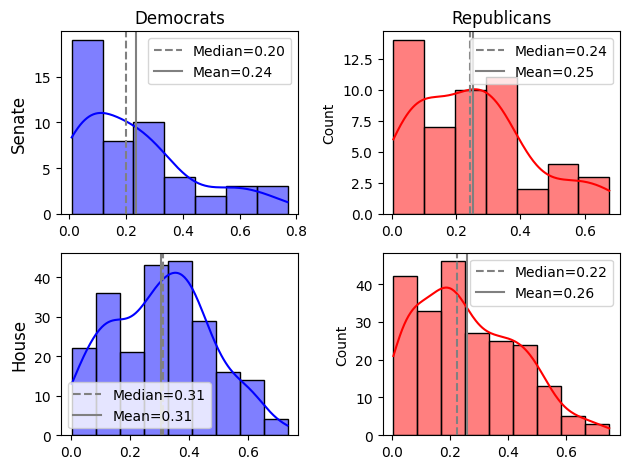

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2)  # Adjust the figsize as needed

senate_democrats = DATABASE[
    (DATABASE["chamber"] == "Senate") & (DATABASE["party"] == "Democrat")
]
senate_republicans = DATABASE[
    (DATABASE["chamber"] == "Senate") & (DATABASE["party"] == "Republican")
]
house_democrats = DATABASE[
    (DATABASE["chamber"] == "House") & (DATABASE["party"] == "Democrat")
]
house_republicans = DATABASE[
    (DATABASE["chamber"] == "House") & (DATABASE["party"] == "Republican")
]


def plot_data(data, title, color, ax):
    diff = data["nominate_dim1"] - data["reduced-projection-1d"]
    median = abs(diff).median()
    mean = abs(diff).mean()

    sns.histplot(abs(diff), color=color, ax=ax, kde=True)
    ax.axvline(median, color="grey", linestyle="--", label=f"Median={median:.2f}")
    ax.axvline(mean, color="grey", linestyle="-", label=f"Mean={mean:.2f}")
    ax.legend()  # Consider adjusting the legend position if needed


# Plot for each subgroup
plot_data(senate_democrats, "Senate Democrats", "blue", axs[0, 0])
plot_data(senate_republicans, "Senate Republicans", "red", axs[0, 1])
plot_data(house_democrats, "House Democrats", "blue", axs[1, 0])
plot_data(house_republicans, "House Republicans", "red", axs[1, 1])

# make a y label for the rows
for ax, row in zip(axs[:, 0], ["Senate", "House"]):
    ax.set_ylabel(row, rotation=90, size="large")

# make a x label for the columns
for ax, col in zip(axs[0], ["Democrats", "Republicans"]):
    ax.set_title(col)

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.savefig(ASSETS_DIR / "voteview_vs_vector.png")  # Save the entire figure

# Projection of the full graph 1d

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming DATABASE is already defined
senate: pd.DataFrame = DATABASE[DATABASE["chamber"] == "Senate"]
house: pd.DataFrame = DATABASE[DATABASE["chamber"] == "House"]

# Create a 2x2 subplot
fig = make_subplots(
    rows=2,
    cols=2,
    shared_xaxes=True,
    subplot_titles=(
        "Senate 2D Projection",
        "House 2D Projection",
        "Senate 1D Projection",
        "House 1D Projection",
    ),
)

# Add 2D projections for Senate
fig.add_trace(
    go.Scatter(
        x=senate["projection-2d_x"],
        y=senate["projection-2d_y"],
        mode="markers",
        marker=dict(
            size=10,
            color=senate["color"],
            colorscale="RdBu",
            showscale=False,
        ),
        text=senate["bioname"],
    ),
    row=1,
    col=1,
)

# Add 2D projections for House
fig.add_trace(
    go.Scatter(
        x=house["projection-2d_x"],
        y=house["projection-2d_y"],
        mode="markers",
        marker=dict(
            size=10,
            color=house["color"],
            colorscale="RdBu",
            showscale=False,
        ),
        text=house["bioname"],
    ),
    row=1,
    col=2,
)

# Add 1D projections for Senate
fig.add_trace(
    go.Scatter(
        x=senate["projection-1d"],
        mode="markers",
        marker_color=senate["color"],
    ),
    row=2,
    col=1,
)

# Add 1D projections for House
fig.add_trace(
    go.Scatter(
        x=house["projection-1d"],
        mode="markers",
        marker_color=house["color"],
    ),
    row=2,
    col=2,
)

# Update layout for the combined figure
fig.update_layout(
    title="Projection of the full graph",
    height=800,
    width=1200,
    showlegend=False,
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
)

# Update y-axes and x-axes as needed
fig.update_yaxes(showticklabels=True, range=[-1, 1], row=1)
fig.update_yaxes(zerolinecolor="black", showticklabels=False, row=2)
fig.update_xaxes(showticklabels=True, range=[-1, 1])

# Save and show the figure
fig.write_image(ASSETS_DIR / f"vector-projection-full.png")
fig.show()

# Absolute distances between full 1d projection and voteview nominate_dim1

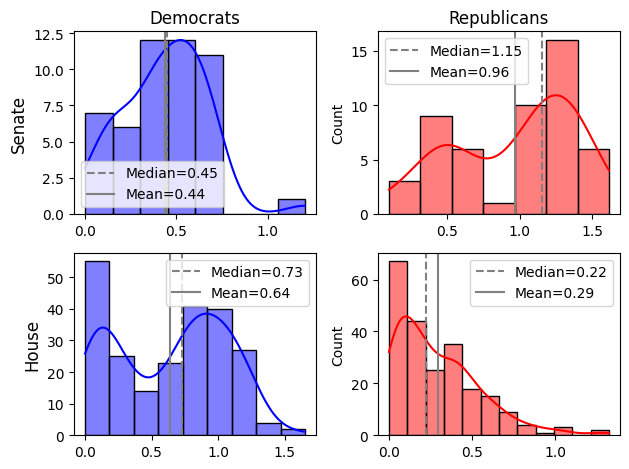

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2)  # Adjust the figsize as needed

senate_democrats = DATABASE[
    (DATABASE["chamber"] == "Senate") & (DATABASE["party"] == "Democrat")
]
senate_republicans = DATABASE[
    (DATABASE["chamber"] == "Senate") & (DATABASE["party"] == "Republican")
]
house_democrats = DATABASE[
    (DATABASE["chamber"] == "House") & (DATABASE["party"] == "Democrat")
]
house_republicans = DATABASE[
    (DATABASE["chamber"] == "House") & (DATABASE["party"] == "Republican")
]


def plot_data(data, title, color, ax):
    diff = data["nominate_dim1"] - data["projection-1d"]
    median = abs(diff).median()
    mean = abs(diff).mean()

    sns.histplot(abs(diff), color=color, ax=ax, kde=True)
    ax.axvline(median, color="grey", linestyle="--", label=f"Median={median:.2f}")
    ax.axvline(mean, color="grey", linestyle="-", label=f"Mean={mean:.2f}")
    ax.legend()  # Consider adjusting the legend position if needed


# Plot for each subgroup
plot_data(senate_democrats, "Senate Democrats", "blue", axs[0, 0])
plot_data(senate_republicans, "Senate Republicans", "red", axs[0, 1])
plot_data(house_democrats, "House Democrats", "blue", axs[1, 0])
plot_data(house_republicans, "House Republicans", "red", axs[1, 1])

# make a y label for the rows
for ax, row in zip(axs[:, 0], ["Senate", "House"]):
    ax.set_ylabel(row, rotation=90, size="large")

# make a x label for the columns
for ax, col in zip(axs[0], ["Democrats", "Republicans"]):
    ax.set_title(col)

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.savefig(ASSETS_DIR / "voteview_vs_full.png")  # Save the entire figure

# Projection of the minimum graph 1d

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming DATABASE is already defined
senate: pd.DataFrame = DATABASE[DATABASE["chamber"] == "Senate"]
house: pd.DataFrame = DATABASE[DATABASE["chamber"] == "House"]

# Create a 2x2 subplot
fig = make_subplots(
    rows=2,
    cols=2,
    shared_xaxes=True,
    subplot_titles=(
        "Senate 2D Projection",
        "House 2D Projection",
        "Senate 1D Projection",
        "House 1D Projection",
    ),
)

# Add 2D projections for Senate
fig.add_trace(
    go.Scatter(
        x=senate["minimum-projection-2d_x"],
        y=senate["minimum-projection-2d_y"],
        mode="markers",
        marker=dict(
            size=10,
            color=senate["color"],
            colorscale="RdBu",
            showscale=False,
        ),
        text=senate["bioname"],
    ),
    row=1,
    col=1,
)

# Add 2D projections for House
fig.add_trace(
    go.Scatter(
        x=house["minimum-projection-2d_x"],
        y=house["minimum-projection-2d_y"],
        mode="markers",
        marker=dict(
            size=10,
            color=house["color"],
            colorscale="RdBu",
            showscale=False,
        ),
        text=house["bioname"],
    ),
    row=1,
    col=2,
)

# Add 1D projections for Senate
fig.add_trace(
    go.Scatter(
        x=senate["minimum-projection-1d"],
        mode="markers",
        marker_color=senate["color"],
    ),
    row=2,
    col=1,
)

# Add 1D projections for House
fig.add_trace(
    go.Scatter(
        x=house["minimum-projection-1d"],
        mode="markers",
        marker_color=house["color"],
    ),
    row=2,
    col=2,
)

# Update layout for the combined figure
fig.update_layout(
    title="Projections of reduced graph structure",
    height=800,
    width=1200,
    showlegend=False,
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
)

# Update y-axes and x-axes as needed
fig.update_yaxes(showticklabels=True, range=[-1, 1], row=1)
fig.update_yaxes(zerolinecolor="black", showticklabels=False, row=2)
fig.update_xaxes(showticklabels=True, range=[-1, 1])

# Save and show the figure
fig.write_image(ASSETS_DIR / f"vector-projection-minimum.png")
fig.show()

# Absolute distances between minimum 1d projection and voteview nominate_dim1

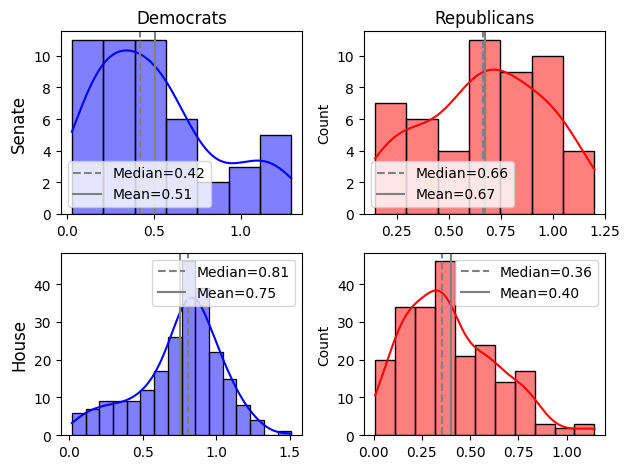

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2)  # Adjust the figsize as needed

senate_democrats = DATABASE[
    (DATABASE["chamber"] == "Senate") & (DATABASE["party"] == "Democrat")
]
senate_republicans = DATABASE[
    (DATABASE["chamber"] == "Senate") & (DATABASE["party"] == "Republican")
]
house_democrats = DATABASE[
    (DATABASE["chamber"] == "House") & (DATABASE["party"] == "Democrat")
]
house_republicans = DATABASE[
    (DATABASE["chamber"] == "House") & (DATABASE["party"] == "Republican")
]


def plot_data(data, title, color, ax):
    diff = data["nominate_dim1"] - data["minimum-projection-1d"]
    median = abs(diff).median()
    mean = abs(diff).mean()

    sns.histplot(abs(diff), color=color, ax=ax, kde=True)
    ax.axvline(median, color="grey", linestyle="--", label=f"Median={median:.2f}")
    ax.axvline(mean, color="grey", linestyle="-", label=f"Mean={mean:.2f}")
    ax.legend()  # Consider adjusting the legend position if needed


# Plot for each subgroup
plot_data(senate_democrats, "Senate Democrats", "blue", axs[0, 0])
plot_data(senate_republicans, "Senate Republicans", "red", axs[0, 1])
plot_data(house_democrats, "House Democrats", "blue", axs[1, 0])
plot_data(house_republicans, "House Republicans", "red", axs[1, 1])

# make a y label for the rows
for ax, row in zip(axs[:, 0], ["Senate", "House"]):
    ax.set_ylabel(row, rotation=90, size="large")

# make a x label for the columns
for ax, col in zip(axs[0], ["Democrats", "Republicans"]):
    ax.set_title(col)

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.savefig(ASSETS_DIR / "voteview_vs_minimum.png")  # Save the entire figure

# Donation distribution for chamber and party

In [12]:
# plot the distribution of donations received by each party splitted by chamber
total_donations = (
    DATABASE.groupby(["chamber", "party"])["donations-in-total"].sum().reset_index()
)
total_donations

,chamber,party,donations-in-total
0,House,Democrat,141755270
1,House,Republican,100390589
2,President,Democrat,7183522
3,President,Republican,0
4,Senate,Democrat,185070833
5,Senate,Other,3162798
6,Senate,Republican,294172322


# Who are the people in 5% of the top donors?

In [17]:
top_donors = DATABASE[
    DATABASE["donations-in-total"] > DATABASE["donations-in-total"].quantile(0.98)
][["bioname", "party", "donations-in-total", "chamber"]]

# sort by donations-in-total
top_donors = top_donors.sort_values(by="donations-in-total", ascending=False)

# format the numbers in "donations-in-total" to be more readable
top_donors["donations-in-total"] = top_donors["donations-in-total"].apply(
    lambda x: f"${x/1000000:.2f}M"
)

# save to a latex table grouped by chamber
print(
    top_donors.groupby("chamber").apply(
        lambda x: x[["bioname", "party", "donations-in-total"]].to_latex(
            index=False, caption=f"Top donors in the {x['chamber'].values[0]}"
        )
    )
)


# top_donors

chamber
House     \begin{table}\n\caption{Top donors in the Hous...
Senate    \begin{table}\n\caption{Top donors in the Sena...
dtype: object

# Sum of total donations for each party and chamber in a bar plot

In [14]:
# Sum of total donations for each party and chamber in a bar plot
import plotly.express as px

# exclude the "Other" party and the "President" chamber
total_donations = total_donations[
    ~(
        (total_donations["party"] == "Other")
        | (total_donations["chamber"] == "President")
    )
]

# democrats should be blue and republicans should be red

fig = px.bar(
    total_donations,
    x="chamber",
    y="donations-in-total",
    color="party",
    barmode="group",
    color_discrete_map={"Democrat": "blue", "Republican": "red"},
)

fig.update_layout(
    title="Total donations received by each party",
    xaxis_title="Party",
    yaxis_title="Total donations",
    height=600,
    width=1000,
    showlegend=True,
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
)
fig.write_image(ASSETS_DIR / "total-donations-by-party.png")
fig.show()

In [15]:
DATABASE

,congress,chamber,icpsr,nominate_dim1,bioname,bioguide_id,party_code,littlesis,party,color,...,projection-2d_y,donations-in-total,donations-from,donations-count,reduced-projection-1d,reduced-projection-2d_x,reduced-projection-2d_y,minimum-projection-1d,minimum-projection-2d_x,minimum-projection-2d_y
0,117,President,99912,0.403,"TRUMP, Donald John",NaN,200,NaN,Republican,red,...,NaN,0,<EMPTY>,0,NaN,NaN,NaN,NaN,NaN,NaN
1,117,President,99913,-0.320,"BIDEN, Joseph Robinette, Jr.",B000444,100,13047.0,Democrat,blue,...,0.889964,7183522,"3492,3652,4900,5563,7369,15923,15931,15948,178...",2795,-1.000000,1.000000,-0.460040,-0.995572,0.474138,-0.985600
2,117,House,20301,0.363,"ROGERS, Mike Dennis",R000575,200,13551.0,Republican,red,...,-0.151795,565540,"16703,18391,21655,21657,23503,26690,18398,1872...",197,0.131765,-0.335325,-0.746212,0.263116,0.078113,0.157985
3,117,House,21102,-0.396,"SEWELL, Terri",S001185,100,45074.0,Democrat,blue,...,-0.057478,458086,"1737,46056,75933,1654,10611,91089,91092,51411,...",255,-0.027317,-0.017581,-0.251750,0.607777,0.075087,-0.127381
4,117,House,21193,0.652,"BROOKS, Mo",B001274,200,91561.0,Republican,red,...,-0.211008,234980,"19516,15149,17426,93158,1654,22293,135469,1355...",84,0.172917,-0.275998,-0.543495,0.126847,-0.176656,0.112243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,117,Senate,40915,-0.058,"MANCHIN, Joe, III",M001183,100,34472.0,Democrat,blue,...,0.433306,1589963,"95304,42142,93158,93176,5303,93451,44916,67913...",640,-0.111620,0.008561,-0.450935,0.654728,0.638862,0.070057
555,117,Senate,29940,-0.492,"BALDWIN, Tammy",B001230,100,12987.0,Democrat,blue,...,0.708188,3953875,"8546,16789,20936,26279,33725,42719,43025,43175...",1411,-0.474648,0.012995,-0.874175,-0.342317,-0.360135,-0.632622
556,117,Senate,41111,0.629,"JOHNSON, Ron",J000293,200,91598.0,Republican,red,...,0.830798,4997028,"95309,15613,16379,6471,34904,37175,48960,47118...",1077,0.610665,-0.898187,-0.027274,-0.274404,-0.082808,0.910473
557,117,Senate,20953,0.691,"LUMMIS, Cynthia M.",L000571,200,91524.0,Republican,red,...,0.050094,422136,"42743,3947,15025,14305,33167,18727,34141,49468...",164,0.756591,-0.570194,0.424099,0.058864,-0.266874,0.197411
